In [1]:
# Install required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Read the two files
df1 = pd.read_csv('/content/hfm_10cols.csv')
df2 = pd.read_csv('/content/hfm_14cols.csv')
df3 = df2.drop(columns = ['Unnamed: 14','Unnamed: 15','label','time'])
df = pd.concat([df1,df3], axis=1)
df = df[['time','failure_label','sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9','sensor_10','sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16','sensor_17','sensor_18','sensor_19','sensor_20']]
df['time'] = pd.to_datetime(df['time'])

In [3]:
# Based on summary statistics dropping the sensor 4,5,9,15,17 and 18
df = df.drop(columns = ['sensor_4','sensor_5','sensor_9','sensor_15','sensor_17','sensor_18'])
df_normal = df[df['failure_label']==0]
df_failure = df[df['failure_label']==1]
# Train and test data
X_train = df_normal.iloc[:,2:]
X_fault = df_failure.iloc[:,2:]
# Scaling the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_fault)

In [4]:
# Define input layer
input_layer = Input(shape=(X_train_scaled.shape[1],))

# Define encoder layers
encoded = Dense(32, activation='ReLU')(input_layer)

#Latent space
latent = Dense(16, activation='ReLU')(encoded )

# Define decoder layers
decoded = Dense(32, activation='ReLU')(latent)
decoded = Dense(X_train_scaled.shape[1], activation='linear')(decoded)

# Define autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile autoencoder model
autoencoder.compile(optimizer='adam', loss='mae')

# Print model summary
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense (Dense)               (None, 32)                480       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 14)                462       
                                                                 
Total params: 2014 (7.87 KB)
Trainable params: 2014 (7.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
642/642 [==============================] - 4s 4ms/step - loss: 0.3200 - val_loss: 0.2850
Epoch 2/100
642/642 [==============================] - 2s 3ms/step - loss: 0.1397 - val_loss: 0.1528
Epoch 3/100
642/642 [==============================] - 1s 2ms/step - loss: 0.0728 - val_loss: 0.0995
Epoch 4/100
642/642 [==============================] - 2s 4ms/step - loss: 0.0496 - val_loss: 0.0754
Epoch 5/100
642/642 [==============================] - 2s 3ms/step - loss: 0.0391 - val_loss: 0.0461
Epoch 6/100
642/642 [==============================] - 1s 1ms/step - loss: 0.0334 - val_loss: 0.0582
Epoch 7/100
642/642 [==============================] - 1s 1ms/step - loss: 0.0309 - val_loss: 0.0338
Epoch 8/100
642/642 [==============================] - 1s 1ms/step - loss: 0.0284 - val_loss: 0.0503
Epoch 9/100
642/642 [==============================] - 1s 2ms/step - loss: 0.0257 - val_loss: 0.0410
Epoch 10/100
642/642 [==============================] - 1s 2ms/step - loss: 0.0226 - val_lo

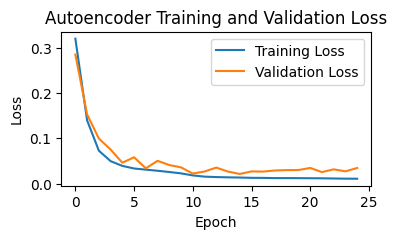

In [5]:
# Define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# Fit autoencoder model with early stopping callback
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled),
                callbacks=[early_stopping_callback])

plt.rcParams['figure.figsize'] = [4, 2]
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Function to obtain reconstruction loss
def recon_loss(NN,X):
    #NN is the trained neural network model
    X_pred = NN.predict(X)
    reconstruction_loss = np.mean((X-X_pred)**2,axis=1)
    return reconstruction_loss

642/642 [==============================] - 1s 1ms/step


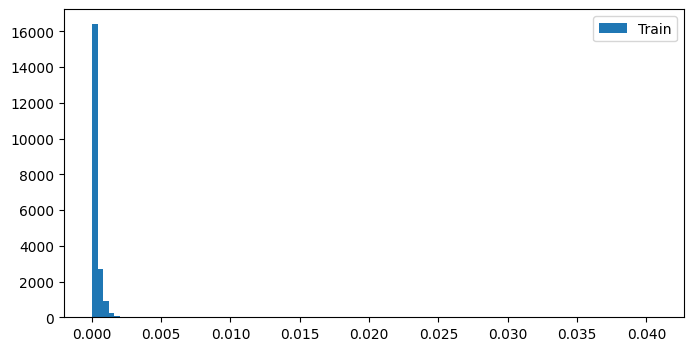

In [7]:
# Histogram for the reconstruction loss of the Fault Free data
Training_reconstruction_loss = recon_loss(NN=autoencoder,X=X_train_scaled)
plt.figure(figsize=(8, 4))
plt.hist(Training_reconstruction_loss, bins=100,label='Train',alpha=1)
plt.legend()
plt.show()

4/4 [==============================] - 0s 3ms/step


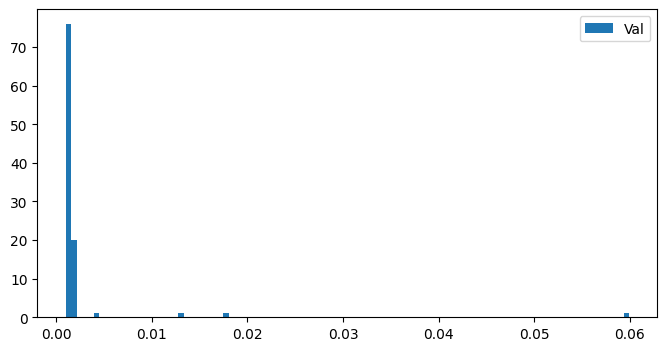

In [8]:
# Histogram for the reconstruction loss of the Faulty data
Validation_reconstruction_loss = recon_loss(NN=autoencoder,X=X_test_scaled)
plt.figure(figsize=(8, 4))
plt.hist(Validation_reconstruction_loss, bins=100,label='Val',alpha=1)
# plt.xlim([0,80])
plt.legend()
plt.show()

645/645 [==============================] - 1s 969us/step


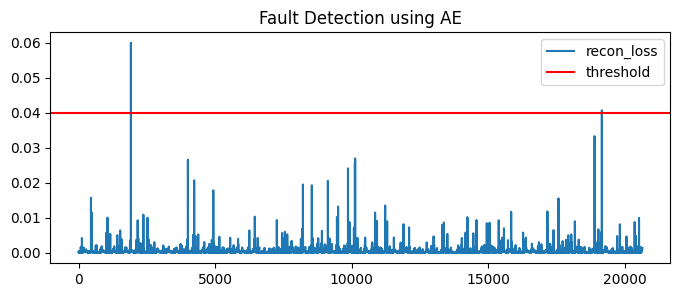

In [9]:
# Fault detection using residuals for the entire data using threshold
threshold = round(max(Training_reconstruction_loss),2)
EntireData = df.iloc[:,2:]
EntireData_scaled = sc.transform(EntireData)
EntireData_reconstruction_loss = recon_loss(NN=autoencoder,X=EntireData_scaled)

plt.rcParams['figure.figsize'] = [8, 3]
plt.plot(EntireData_reconstruction_loss,label=f'recon_loss')
plt.axhline(threshold,c='r',label='threshold')    #threshold value

plt.title(f'Fault Detection using AE')
plt.legend()
plt.show()

In [10]:
# Counting number of samples above threshold
mask = np.array(EntireData_reconstruction_loss) >= threshold
count_true = np.sum(mask)
indices = np.where(mask)
selected_rows = df.iloc[indices]
selected_rows.shape[0]

2

In [11]:
# Counting number of faults detected by model
(selected_rows.shape[0]-(sum(selected_rows['failure_label'] == 0)))

1

In [12]:
#Calculationg accuracy
Accuarcy = (selected_rows.shape[0]-(sum(selected_rows['failure_label'] == 0))) / selected_rows.shape[0]
Accuarcy

0.5